Playing with data from <https://github.com/oscartackstrom/sentence-sentiment-data>.

One document looks like this:

```
books_neg_2
books   2
neg     The book is disproportionally focused on single and multilayer feedforward networks.
neg     And though the book puts great emphasis on mathematics and even includes a big section on important mathematical background knowledge, it contains to many errors in the mathematical formulas, so they are of little use.
neg     The author hasn't even taken the trouble to put up an errata list.
neg     Finally, for the beginner there are not enough conceptual clues on what is actually going on and it is hard to form any mental model of the underlying processes.
neg     There are better books.
neu     For an introduction read Neural Networks by Kevin Gurney. He puts great emphasis on conceptual understanding.
neu     For further studies there is Neural Networks by Simon Haykin, which has the mathematics.
```

In [95]:
from collections import Counter
import gzip
import matplotlib.pyplot as plt
import numpy as np
from numpy import array as npa
import re
from scipy.sparse import vstack
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tabulate import tabulate
%matplotlib inline

In [96]:
class Document(object):
    def __init__(self, raw_text):
        self.sentences = raw_text.split("\n\n")
        self.doc_label = self.sentences[0]
        self.sentences = npa(self.sentences[2:]) # ignoring product type
        self.doc_label = re.findall(r'^.*_(.+?)_.*', self.doc_label)[0]
        self.sent_labels = npa([s.split('\t')[0] for s in self.sentences])
        self.sentences = npa([s.split('\t')[1] for s in self.sentences])
        

def read_data(filename):
    all_data = '\n'.join(gzip.open(filename, 'rt').readlines())
    documents = [Document(d) for d in all_data.split('\n\n\n\n')]
    return npa(documents)

def count_sentences(docs):
    return sum(len(d.sent_labels) for d in docs)

def count_sentence_labels(docs):
    counts = Counter()
    for d in docs:
        counts.update(d.sent_labels)
    return counts

documents = read_data('finegrained.txt.gz')
print('read %d documents with %d sentences' % (len(documents), count_sentences(documents)))
print('document label distribution: %s' % Counter(d.doc_label for d in documents))
print('sentence label distribution: %s' % count_sentence_labels(documents))

read 294 documents with 3836 sentences
document label distribution: Counter({'neg': 99, 'neu': 98, 'pos': 97})
sentence label distribution: Counter({'neg': 1320, 'nr': 1147, 'pos': 923, 'neu': 272, 'mix': 174})


In [97]:
# set mix and nr -> neu (as in Tackstrom & McDonald)
def set_nr_to_neu(documents):
    for d in documents:
        d.sent_labels = npa(['neu' if s in ['mix', 'nr'] else s for s in d.sent_labels])
        
set_nr_to_neu(documents)
print('after converting [mix|nr]->neu, sentence label distribution: %s' % count_sentence_labels(documents))

after converting [mix|nr]->neu, sentence label distribution: Counter({'neu': 1593, 'neg': 1320, 'pos': 923})


In [98]:
# remove neutral documents.
documents = npa([d for d in documents if d.doc_label != 'neu'])
print('%d documents remain' % len(documents))
print('document label distribution: %s' % Counter(d.doc_label for d in documents))
print('sentence label distribution: %s' % count_sentence_labels(documents))

196 documents remain
document label distribution: Counter({'neg': 99, 'pos': 97})
sentence label distribution: Counter({'neu': 896, 'neg': 837, 'pos': 727})


In [99]:
def featurize(documents):
    vec = CountVectorizer(min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))
    def iterate_sentences(documents):
        for d in documents:
            for s in d.sentences:
                yield s
                
    X = vec.fit_transform(iterate_sentences(documents))
    start = 0
    for d in documents:
        end = start + len(d.sentences)
        d.sentence_matrix = X[start:end]
        start = end
    return vec

vec = featurize(documents)
print('%d features' % len(vec.get_feature_names()))

3756 features


In [100]:
def print_top_feats(clf, vec, n=10):
    feats = npa(vec.get_feature_names())
    coefs = clf.coef_
    if coefs.shape[0] == 1:
        coefs = [-1 * coefs[0], coefs[0]]
    for ci, cname in enumerate(clf.classes_):
        coef = coefs[ci]
        print('\n' + cname + '\n-----')
        print('\n'.join('%s=%.4f' % (feats[i], coef[i]) for i in np.argsort(coef)[::-1][:n]))

In [101]:
"""
Do cross-validation, reporting how often the sentence returned
by the student has a true label that matches the document label.
"""
def expt(documents, fit_fn, predict_fn, n_folds=5, seed=1234):
    cv = KFold(len(documents), n_folds=n_folds, shuffle=True, random_state=seed)
    doc_preds = []
    sent_preds = []
    doc_truths = []
    sent_truths = []
    for traini, testi in cv:
        train_docs = documents[traini]
        test_docs = documents[testi]
        clf = fit_fn(train_docs, seed)
        this_doc_preds, this_sent_preds = predict_fn(clf, test_docs, seed)
        doc_preds.extend(this_doc_preds)
        sent_preds.extend(this_sent_preds)
        doc_truths.extend(d.doc_label for d in test_docs)
        sent_truths.extend(np.concatenate([d.sent_labels for d in test_docs]))
    doc_acc = accuracy_score(doc_preds, doc_truths)
    doc_preds = npa(doc_preds)
    doc_truths = npa(doc_truths)
    nonneutr = [i for i, l in enumerate(doc_preds) if l != 'neu']
    nonneutr_acc = accuracy_score(doc_preds[nonneutr], doc_truths[nonneutr])
    neutr_pct = 1 - 1 * (len(nonneutr) / len(doc_preds))
    print('oracle acc=%.3f acc w/o neutral=%.3f pct neutral=%.3f' %
          (doc_acc, nonneutr_acc, neutr_pct))
    #print('document accuracy:')
    #print(classification_report(doc_truths, doc_preds))
    print(confusion(doc_truths, doc_preds, sorted(set(doc_preds))))
    sent_acc = accuracy_score(sent_preds, sent_truths)
    print('sentence accuracy=%.3f' % sent_acc)
    #print(classification_report(sent_truths, sent_preds))
    # retrain on all.
    clf = fit_fn(documents, seed)
    return clf, nonneutr_acc, neutr_pct


def confusion(truths, preds, labels):
    m = confusion_matrix(truths, preds, labels=labels)
    labels = [l[:4] for l in labels]
    m = np.vstack((labels, m))
    m = np.hstack((np.matrix([''] + list(labels)).T, m))
    return tabulate(m.tolist(), headers='firstrow')

In [102]:
results = {}

In [103]:
# Use document label as sentence label at training time (DaS="document as sentence")
def get_label_of_most_confident_sentence(probas, doc):
    # Find true sentence label of most confident sentence.
    # This simulates what the oracle would return if we
    # returned the most confident sentence.
    return doc.sent_labels[probas.max(axis=1).argmax()]

def fit_lr(documents, seed):
    X = vstack((d.sentence_matrix for d in documents))
    # duplicate doc label for each sentence.
    y = np.concatenate([[d.doc_label] * len(d.sentences) for d in documents])
    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

def predict_lr(clf, documents, seed, thresh=.6):
    # label as neutral sentences with max posterior < thresh.
    doc_preds = []
    sent_preds = []
    for d in documents:
        probas = clf.predict_proba(d.sentence_matrix)
        preds = clf.predict(d.sentence_matrix)
        doc_preds.append(get_label_of_most_confident_sentence(probas, d))
        neu_idx = [i for i, p in enumerate(probas) if p.max() < thresh]
        preds[neu_idx] = 'neu'
        sent_preds.extend(preds)
    return doc_preds, sent_preds

clf, acc, neut = expt(documents, fit_lr, predict_lr)
print_top_feats(clf, vec)
results['DaS'] = (acc, neut)

oracle acc=0.643 acc w/o neutral=0.962 pct neutral=0.332
       neg    neu    pos
---  -----  -----  -----
neg     65     31      3
neu      0      0      0
pos      2     34     61
sentence accuracy=0.400

neg
-----
were=1.6503
movie=1.6080
waste=1.4356
bag=1.3727
novel=1.3407
weapons=1.2985
please=1.2609
beyonce=1.1895
headset=1.1507
poor=1.1432

pos
-----
battery=1.3204
perfect=1.3037
sing=1.2362
camera=1.2040
spiritual=1.1938
ceedee=1.1789
isn=1.1527
its=1.1213
sense=1.0525
zoom=1.0349


In [104]:
# Use true sentence label as sentence label (Fine)
def fit_lr_sent_labels(documents, seed):
    X = vstack((d.sentence_matrix for d in documents))
    y = np.concatenate([d.sent_labels for d in documents])
    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

def predict_lr_sent_labels(clf, documents, seed):
    doc_preds = []
    sent_preds = []
    # ignore neutral labels.
    neu_idx = np.where(clf.classes_ == 'neu')[0]
    for d in documents:
        probas = clf.predict_proba(d.sentence_matrix)
        probas[:,neu_idx] = 0
        preds = clf.predict(d.sentence_matrix)
        doc_preds.append(get_label_of_most_confident_sentence(probas, d))
        sent_preds.extend(preds)
    return doc_preds, sent_preds

clf, acc, neut = expt(documents, fit_lr_sent_labels, predict_lr_sent_labels)
print_top_feats(clf, vec)
results['Fine'] = (acc, neut)

oracle acc=0.633 acc w/o neutral=0.905 pct neutral=0.301
       neg    neu    pos
---  -----  -----  -----
neg     62     30      7
neu      0      0      0
pos      6     29     62
sentence accuracy=0.485

neg
-----
boring=1.7935
hear=1.3839
terrible=1.3595
waste=1.2567
unfortunately=1.2460
annoying=1.2202
money=1.2157
belly=1.2086
put=1.1926
felt=1.1855

neu
-----
watch=1.6561
isn=1.4517
released=1.4494
x=1.3380
box=1.2395
wise=1.2314
wants=1.2184
dance=1.1918
mean=1.1635
women=1.1120

pos
-----
enjoyed=1.6444
perfect=1.6117
funny=1.4661
negative=1.2835
amazing=1.2538
excellent=1.2383
great=1.1795
easy=1.1595
large=1.1393
match=1.1340


Fitting with sentence labels actually hurts accuracy slightly, while helping neutrality.

I think part of what's happening is that Fine has a better model of neutrality, since it actually has labeled data for it. This sacrifices somewhat pos/neg accuracy.

Looking at the top terms, Fine looks a lot better than DaS.

In [105]:
# Cheat by returning the sentence with the maximum predicted probability
# according to the *known* document label.
def predict_lr_cheat_doc(clf, documents, seed, thresh=.6):
    # label as neutral sentences with max posterior < thresh.
    doc_preds = []
    sent_preds = []
    for d in documents:
        probas = clf.predict_proba(d.sentence_matrix)
        preds = clf.predict(d.sentence_matrix)
        true_idx = np.where(clf.classes_==d.doc_label)[0]
        doc_preds.append(d.sent_labels[probas[:, true_idx].argmax()])
        neu_idx = [i for i, p in enumerate(probas) if p.max() < thresh]
        preds[neu_idx] = 'neu'
        sent_preds.extend(preds)
    return doc_preds, sent_preds

clf, acc, neut = expt(documents, fit_lr, predict_lr_cheat_doc)
results['DaS+Cheat'] = (acc, neut)
# print_top_feats(clf, vec)

oracle acc=0.648 acc w/o neutral=0.969 pct neutral=0.332
       neg    neu    pos
---  -----  -----  -----
neg     67     31      1
neu      0      0      0
pos      3     34     60
sentence accuracy=0.400


This only helps DaS by correcting exactly one document.

In [106]:
# Cheating expt using sentence labels at training time.
def predict_lr_sent_labels_cheat_doc(clf, documents, seed):
    # label as neutral sentences with max posterior < thresh.
    doc_preds = []
    sent_preds = []
    for d in documents:
        probas = clf.predict_proba(d.sentence_matrix)
        preds = clf.predict(d.sentence_matrix)
        true_idx = np.where(clf.classes_==d.doc_label)[0]
        doc_preds.append(d.sent_labels[probas[:, true_idx].argmax()])
        sent_preds.extend(preds)
    return doc_preds, sent_preds

clf, acc, neut = expt(documents, fit_lr_sent_labels, predict_lr_sent_labels_cheat_doc)
# print_top_feats(clf, vec)
results['Fine+Cheat'] = (acc, neut)

oracle acc=0.735 acc w/o neutral=0.954 pct neutral=0.230
       neg    neu    pos
---  -----  -----  -----
neg     72     25      2
neu      0      0      0
pos      5     20     72
sentence accuracy=0.485


Cheating helps Fine a lot more than DaS.

In [107]:
# Returning the sentence with the maximum predicted probability
# according to the *predicted* document label.
# The predicted document label is obtained by summing the feature vectors
# for all sentences and classifying the resulting vector.
def predict_lr_pred_doc(clf, documents, seed, thresh=.6):
    doc_preds = []
    sent_preds = []
    for d in documents:
        # sum sentence feature vectors and predict.
        this_doc_pred = clf.predict(d.sentence_matrix.sum(axis=0))
        probas = clf.predict_proba(d.sentence_matrix)
        preds = clf.predict(d.sentence_matrix)
        true_idx = np.where(clf.classes_==this_doc_pred)[0]
        doc_preds.append(d.sent_labels[probas[:, true_idx].argmax()])
        neu_idx = [i for i, p in enumerate(probas) if p.max() < thresh]
        preds[neu_idx] = 'neu'
        sent_preds.extend(preds)
    return doc_preds, sent_preds

clf, acc, neut = expt(documents, fit_lr, predict_lr_pred_doc)
results['DaS+Pred'] = (acc, neut)
# print_top_feats(clf, vec)

oracle acc=0.628 acc w/o neutral=0.969 pct neutral=0.352
       neg    neu    pos
---  -----  -----  -----
neg     64     33      2
neu      0      0      0
pos      2     36     59
sentence accuracy=0.400


Compared to ignoring document label, minimal improvement to accuracy, hurts neutral.

In [108]:
# Returning the sentence with the maximum predicted probability
# according to the *predicted* document label.
# The predicted document label is obtained by summing the feature vectors
# for all sentences and classifying the resulting vector.
def predict_lr_sent_labels_pred_doc(clf, documents, seed):
    doc_preds = []
    sent_preds = []
    neu_label_idx = np.where(clf.classes_ == 'neu')[0]
    for d in documents:
        # sum sentence feature vectors and predict.
        this_doc_pred_proba = clf.predict_proba(d.sentence_matrix.sum(axis=0))[0]
        this_doc_pred_proba[neu_label_idx] = 0
        this_doc_pred_idx = this_doc_pred_proba.argmax()
        this_doc_pred = clf.classes_[this_doc_pred_idx]
        probas = clf.predict_proba(d.sentence_matrix)
        probas[:,neu_label_idx] = 0
        preds = clf.predict(d.sentence_matrix)
        doc_preds.append(d.sent_labels[probas[:, this_doc_pred_idx].argmax()])        
        sent_preds.extend(preds)
    return doc_preds, sent_preds

clf, acc, neut = expt(documents, fit_lr_sent_labels, predict_lr_sent_labels_pred_doc)
results['Fine+Pred'] = (acc, neut)

oracle acc=0.663 acc w/o neutral=0.909 pct neutral=0.270
       neg    neu    pos
---  -----  -----  -----
neg     65     26      8
neu      0      0      0
pos      5     27     65
sentence accuracy=0.485


Compared to ignoring document label, minimal improvement to accuracy, but helps neutrality a fair bit (6 docs).

In [109]:
print(tabulate([[k, v[0], v[1]] for k,v in sorted(results.items())], headers=['method', 'accuracy', 'neutrality']))

method        accuracy    neutrality
----------  ----------  ------------
DaS           0.961832      0.331633
DaS+Cheat     0.969466      0.331633
DaS+Pred      0.968504      0.352041
Fine          0.905109      0.30102
Fine+Cheat    0.953642      0.229592
Fine+Pred     0.909091      0.270408


pos/neg weight=0.1000
oracle acc=0.724 acc w/o neutral=0.947 pct neutral=0.235
       neg    neu    pos
---  -----  -----  -----
neg     74     21      4
neu      0      0      0
pos      4     25     68
sentence accuracy=0.431
pos/neg weight=0.2000
oracle acc=0.714 acc w/o neutral=0.946 pct neutral=0.245
       neg    neu    pos
---  -----  -----  -----
neg     72     22      5
neu      0      0      0
pos      3     26     68
sentence accuracy=0.465
pos/neg weight=0.3000
oracle acc=0.704 acc w/o neutral=0.945 pct neutral=0.255
       neg    neu    pos
---  -----  -----  -----
neg     70     24      5
neu      0      0      0
pos      3     26     68
sentence accuracy=0.482
pos/neg weight=0.4000
oracle acc=0.694 acc w/o neutral=0.938 pct neutral=0.260
       neg    neu    pos
---  -----  -----  -----
neg     71     23      5
neu      0      0      0
pos      4     28     65
sentence accuracy=0.480
pos/neg weight=0.5000
oracle acc=0.694 acc w/o neutral=0.944 pct neutral=0.265
       ne

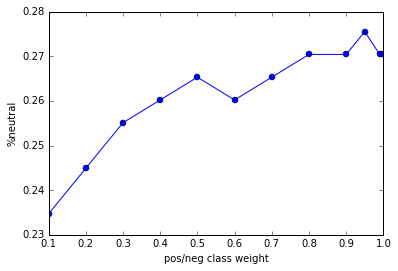

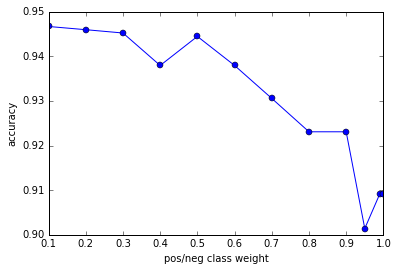

In [110]:
# Try weighting neutrality more.
class Weighted(object):
    def __init__(self, neu, pos, neg):
        self.neu = neu
        self.pos = pos
        self.neg = neg
    
    def fit(self, documents, seed):
        X = vstack((d.sentence_matrix for d in documents))
        y = np.concatenate([d.sent_labels for d in documents])
        clf = LogisticRegression(class_weight={'neu': self.neu, 'pos': self.pos, 'neg': self.neg})
        clf.fit(X, y)
        return clf
        
accs = []
neuts = []
weights = np.arange(10)/10
weights = np.concatenate((weights, (.95, .99, .999)))
weights = weights[1:]
for w in weights:
    print('pos/neg weight=%.4f' % w)
    clf, acc, neut = expt(documents, Weighted(1, w, w).fit, predict_lr_sent_labels_pred_doc)
    accs.append(acc)
    neuts.append(neut)
    
print(tabulate(zip(weights, accs, neuts), headers=['pos/neg weight', 'accuracy', 'neutrality']))
plt.figure()
plt.plot(weights, neuts, 'bo-')
plt.xlabel('pos/neg class weight')
plt.ylabel('%neutral')
plt.show()
plt.figure()
plt.plot(weights, accs, 'bo-')
plt.xlabel('pos/neg class weight')
plt.ylabel('accuracy')
plt.show()